## Milestone 1

**Get the data of the 2 newspapers (Journal de Genève and Gazette de Lausanne), predecessors to Le Temps, and start exploring it using Pandas in an IPython notebook.**<br>
Play with SPARQL request from the website to get on-demand and precise data. http://www.letempsarchives.ch/sparql
Fill the project repo with a notebook containing data collection and descriptive analysis, properly commented.
Update the notebook with a more structured and informed time plan for what comes next (till the presentation).

## Milestone 2

**Pre-processing goals:**<br>
In the second part of the project we aimed to familiarize with our dataset and explore its possibilities in order to decide what trends we want to extract out of it. We first take into account the archives of both the Gazette de Lausanne (GDL) and the Journal de Genève (JDG) during the 20th century. It restricts our dataset to a 100 years for both our journals. Now, we want to study the evolution of environnemental causes interests in the public space. Therefore, we are in a first part going to estimate this evolution and the eventual rises in society awareness on the topics related to these causes. 

**Pre-processing pipeline (Part 1):**<br>
We wanted to set up a basic pipeline in order to get a better view of what our dataset can offer and decide afterwards in which directions we could go on with our work. The below detailed pipeline is exectued for each journal separately.
- First, we extract all the archives from the 20th century of both our journals. Theses archives are xml files. We are therefore going to use the Beautiful Soup html parser to get a sense of what it contains. 
- From our own exploration of the dataset, we saw that all the articles had the following tags coming along: "name" to charaterize the name of the article and "issue_date" to indicate the date when the article was released in the journal. Thus, we are again going to use Beautiful Soup methods. Here, "find_all" will help us retrieve all the content of the previously mentioned tags that matter to our analysis. 
- Once that their content is retrieved we use the text attribute to put the names and issue dates of all articles in two separate lists. Each list is the size of the number of articles archived during the 20th century.
- After that we can verify that the articles and issue dates lists are of same length and it is indeed the case for both journals.

**Pre-processing pipeline (Part 2):**<br>
In this second part, we want to learn information about the extracted data. 
- To begin, we are putting each list into a pandas series.
- After that, we want to relate issue dates and the title of their related article. So we create 2 dataframes (one for each journal) with two columns: Issue dates and articles names.
- The format of the issue dates is propice to convert the related column into the datetime format.

**Pre-processing pipeline (Part 3):**<br>
We have encountered untitled articles in both journals. To begin, we have ignored these untitled articles in milestone 2 to play around with the data and get a sense of what analysis we could do with our data.
- We have extracted all articles which title contains the word 'écologie' or 'environnement' and we have plotted the occurences of this articles over time. It has helped us see what kind of trends we could hope for by extracting "green" articles from our data.

## What comes next:
This first pre-processing can not by the few terms examined render perfectly and precisely the information from our data. However, the chosen terms are quite general and can be the most probable to be used. So the observations made can give us serious hints on what to do for the pursuit of our analysis.
- One necessary thing to do is to retrieve a set of envrionnemental causes related terms and examine their occurences in the dataset. It will help us determine when the main peaks of information on these related subjects really are.
- After that, we have to know more about what these articles talk about and extract information from it. So one important thing to do is, once we have understood when the important years of publication are, we want to build a new set of data with the articles full content. We are then going to use these wholes articles to understand what the really talk about and especially what is the context that makes the journals talk about environnemental causes. Optionnally, we are going to try and learn the kind of tone they use to treat these topics. Is it done in a scaring manner? Preventing manner? This first objective involves machine learning algorithms which we will use in order to retrieve other subjects treated in these articles as a way to find out more about the context in which they were written. We intent to use the sklearn tools to do some vectorization on the text to extract our features and use algorithms such as LDA or NMF to perform topic modeling.

We are close to having finished the optimal pre-processing part and we are going to go on with the objective mentioned above (Topic Modeling) up to Milestone 3. 

## Milestone 3

From Milestone 2, we have determine a list of steps to perform to get to good topic modeling:
- How many untitled articles over time and total are there in the datasets? After having dealt with this question, we can choose a strategy to deal with untitled articles
- Grow our taxomony list of words to extract "green" articles from the dataset
- Filter "green" articles by title and then retrieve full content
- Statistics on extracted articles (problem need to be qualified and quantified)
- Perform topic modeling

# Important information

This notebook is not the exact continuation of the one handed out for milestone 2 as we have done a lot of data processing and with our very dense dataset we needed to extract a lot of it out in pickle files. Therefore, we explained everytime how the step was performed before dumping the data in pickle files. At the end of milestone 2, we had extracted the list of articles which contained words "environnement" and "écologie" in their title only and we had plotted their number of occurences over time. We had not yet dealt with the untitled articles handling.
<br><br>
Following this link: https://drive.google.com/drive/folders/1qYes6EEqj7pX1nKn0Q0sUiJmye9t-Qay?usp=sharing
You will find all the data we extracted and that we reach out for using pickle.
The folder architecture is the following:
- Mylist.csv : the list of "green" words
- pickle_data/ : 
    - articles/ : folder that gathers all the full text content of "green" articles both titled and untitled articles
    - pandas dataframes and lists useful for our analysis

# Part 1

**Imports and paths to the data of both journals**

In [3]:
# imports
import pandas as pd
import numpy as np
import os
from collections import defaultdict
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pylab
from operator import itemgetter 
%matplotlib inline

import pickle

In [4]:
ADA_DIR = "."
DATA_FOLDER = os.path.join(ADA_DIR, "data")
DATA_FOLDER_GDL = os.path.join(DATA_FOLDER, "GDL")
DATA_FOLDER_JDG = os.path.join(DATA_FOLDER, "JDG")
PICKLE_DATA_FOLDER = os.path.join(ADA_DIR, "pickle_data")
ARTICLES_FOLDER = os.path.join(PICKLE_DATA_FOLDER, "articles")

**Retrieving of all directories with archives for both journals**

In [5]:
listing_gdl = os.listdir(DATA_FOLDER_GDL)

listing_jdg = os.listdir(DATA_FOLDER_JDG)

**Here, we get rid of the 17th and 18th centuries folders as well as of hidden folders**

In [6]:
prefixes = ('17', '18','.')
for dir_ in listing_gdl[:]:
    if dir_.startswith(prefixes):
        listing_gdl.remove(dir_)
        
for dir_ in listing_jdg[:]:
    if dir_.startswith(prefixes):
        listing_jdg.remove(dir_)

**Retrieving articles' titles and related issue dates from pickle**

Here is the code used to retrieve the articles' titles list and relative issue dates from the GDL before dumping them into pickle files: 

    articles_names_gdl = []
    dates_gdl = []

    for infile_gdl in listing_gdl : 
        sublisting_gdl = os.listdir(DATA_FOLDER_GDL+infile_gdl)
        for insubfile_gdl in sublisting_gdl:
            display(infile_gdl+'/'+insubfile_gdl);
            file = open(DATA_FOLDER_GDL+infile_gdl+'/'+insubfile_gdl)
            page = file.read()

            soup = BeautifulSoup(page, 'html.parser')
            all_articles_name_gdl = soup.find_all('name')
            all_articles_date_gdl = soup.find_all('issue_date')
            for i in range(len(all_articles_date_gdl)):
                articles_names_gdl.append(all_articles_name_gdl[i].text)
                dates_gdl.append(all_articles_date_gdl[i].text)
                
Same code was used to retrieve issue dates and articles' titles from the JDG.

In [7]:
gdl_articles_titles_filename = os.path.join(PICKLE_DATA_FOLDER, "gdl_articles_titles")
obj = open(gdl_articles_titles_filename, 'rb')
articles_names_gdl = pickle.load(obj, encoding = 'utf8')

In [8]:
jdg_articles_titles_filename = os.path.join(PICKLE_DATA_FOLDER, "jdg_articles_titles")
obj = open(jdg_articles_titles_filename, 'rb')
articles_names_jdg = pickle.load(obj, encoding = 'utf8')

In [9]:
gdl_issue_dates_filename = os.path.join(PICKLE_DATA_FOLDER, "gdl_issue_dates")
obj = open(gdl_issue_dates_filename, 'rb')
dates_gdl = pickle.load(obj, encoding = 'utf8')

In [10]:
jdg_issue_dates_filename = os.path.join(PICKLE_DATA_FOLDER, "jdg_issue_dates")
obj = open(jdg_issue_dates_filename, 'rb')
dates_jdg = pickle.load(obj, encoding = 'utf8')

In [11]:
print('# of articles (GDL): ', len(articles_names_gdl), '\n', '# of articles (JDG): ', len(articles_names_jdg))

# of articles (GDL):  2184812 
 # of articles (JDG):  2912098


In [12]:
print('# of issue dates (GDL): ', len(dates_gdl), '\n', '# of issue dates (JDG): ', len(dates_jdg))

# of issue dates (GDL):  2184812 
 # of issue dates (JDG):  2912098


The below numbers show that the extraction of both articles' titles and issue dates was done correctly.

# Part 2

**Retrieving dataframes with issue dates and articles' titles columns from pickle**

In [13]:
df_jdg = pd.read_pickle(os.path.join(PICKLE_DATA_FOLDER, 'df_jdg'))
df_gdl = pd.read_pickle(os.path.join(PICKLE_DATA_FOLDER, 'df_gdl'))

Here is the code used to create these dataframes before dumping them into pickle files:

    s_articles_gdl = pd.Series( (v for v in articles_names_gdl) )
    s_dates_gdl = pd.Series( (v for v in dates_gdl) )

    s_articles_jdg = pd.Series( (v for v in articles_names_jdg) )
    s_dates_jdg = pd.Series( (v for v in dates_jdg) )

    df_gdl = pd.DataFrame(s_dates_gdl, columns=['Issue Dates (GDL)'])
    df_gdl['Articles Names (GDL)'] = s_articles_gdl

    df_jdg = pd.DataFrame(s_dates_jdg, columns=['Issue Dates (JDG)'])
    df_jdg['Articles Names (JDG)'] = s_articles_jdg

We have used the above extracted lists to create these dataframes.

In [14]:
df_jdg.head()

,Issue Dates (JDG),Articles Names (JDG)
0,1900-01-01,1&99
1,1900-01-01,1&99
2,1900-01-01,Untitled Article
3,1900-01-01,une fois le cercueil de l'ancien président ren...
4,1900-01-01,Untitled Article


In [15]:
df_gdl.head()

,Issue Dates (GDL),Articles Names (GDL)
0,1900-01-02,"Lausanne,2janvier1900. Regards en arrière"
1,1900-01-02,LES JUSTES
2,1900-01-02,A propos du colonel Lecomte.
3,1900-01-02,LETTRE DE PARIS
4,1900-01-02,Untitled Article


# Part 3

**Handling of untitled articles**<br><br>
As we can see on head of the above dataframes, there appear to be untitled articles in both datasets. Therefore, one main question arises: **How many untitled articles over total per issue year date are there over time?** Answering this question will allow us to understand the impact of this untitled articles on our dataset and correct the eventual bias brought in. 

In [16]:
#jdg 
df_jdg_untitled_articles = df_jdg[df_jdg['Articles Names (JDG)'].str.contains("Untitled Article")]

In [17]:
print(len(df_jdg_untitled_articles),'untitled articles in the JDG')

947051 untitled articles in the JDG


**Count # of untitled articles per year**

In [18]:
df_jdg_untitled_articles_counts = df_jdg_untitled_articles['Issue Dates (JDG)'].dt.year.value_counts().sort_index()

In [19]:
df_jdg_untitled_articles_counts.head()

1900    11542
1901     9839
1902     9724
1903     9064
1904     9373
Name: Issue Dates (JDG), dtype: int64

**Calculate rate of untitled articles over total per issuing year date**

In [20]:
df_jdg_untitled_articles_rates = df_jdg_untitled_articles_counts / df_jdg['Issue Dates (JDG)'].dt.year.value_counts()

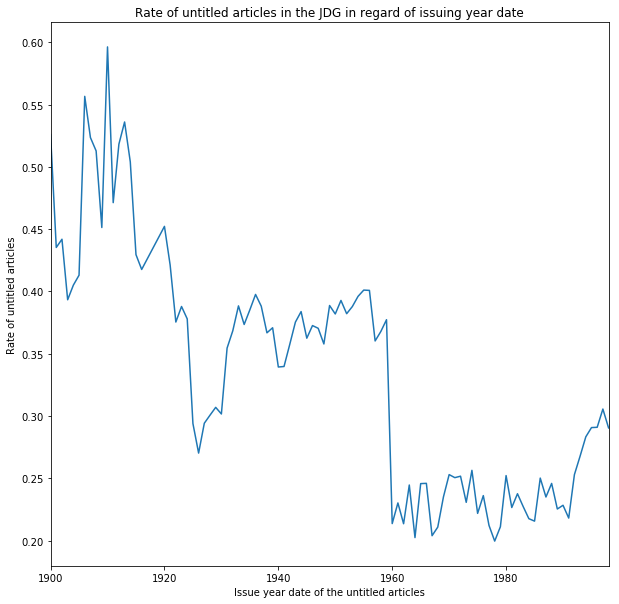

In [21]:
fig = plt.figure(figsize=(10, 10))
df_jdg_untitled_articles_rates.plot()
plt.title('Rate of untitled articles in the JDG in regard of issuing year date')
plt.xlabel('Issue year date of the untitled articles')
plt.ylabel('Rate of untitled articles')
pylab.savefig('UA_overTotal_jdg.png')

**Observation:**<br>
For the JDG, most of the untitled articles go back to the first decades of the 20th century from 1900 to 1920. The rates decrease consideratly afterwards. 

In [22]:
#gdl
df_gdl_untitled_articles = df_gdl[df_gdl['Articles Names (GDL)'].str.contains("Untitled Article")]

In [23]:
print(len(df_gdl_untitled_articles),'untitled articles in the gdl')

636655 untitled articles in the gdl


**Count # of untitled articles per issue year**

In [24]:
df_gdl_untitled_articles_counts = df_gdl_untitled_articles['Issue Dates (GDL)'].dt.year.value_counts().sort_index()

In [25]:
df_gdl_untitled_articles_counts.head()

1900    3698
1901    4151
1902    3094
1903    2942
1904    3434
Name: Issue Dates (GDL), dtype: int64

**Calculate rate of untitled articles over total per issuing year date**

In [26]:
df_gdl_untitled_articles_rates = df_gdl_untitled_articles_counts / df_gdl['Issue Dates (GDL)'].dt.year.value_counts()

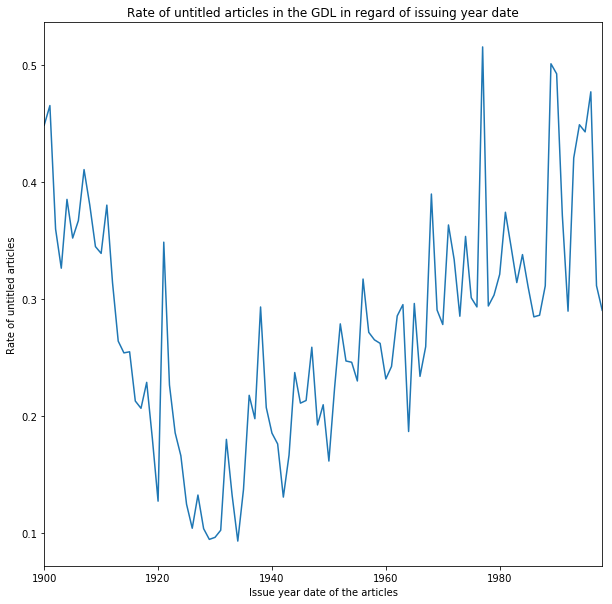

In [27]:
fig = plt.figure(figsize=(10, 10))
df_gdl_untitled_articles_rates.plot()
plt.title('Rate of untitled articles in the GDL in regard of issuing year date')
plt.xlabel('Issue year date of the articles')
plt.ylabel('Rate of untitled articles')
pylab.savefig('UA_overTotal_gdl.png')

**Observation:**<br>
For the GDL, there is no clear pattern as the rates decrease around 1930 before raising back to an approximative 40% rate as it was for the beginning of the century. 

# Part 3

**Retrieving of untitled articles' content to rescue "green" articles**

In [28]:
import re

# function to match "green" words in articles' titles or first words of untitled articles' content
def findWholeWord(w):
    return re.compile(r'\b({0})\b'.format(w), flags=re.IGNORECASE).search

Below is the code used to retrieve the content of untitled articles talking about environmental topics (GDL case, same for JDG). We found out about these "green" untitled articles by looking at the first words of their content and looking for matching words from our "green" list of words.
    # list of "green" words
    vocab=list(pd.read_csv(DATA_FOLDER+"/Mylist.csv",header=None, squeeze = True))

    # get all the dates with untitled articles to look into the xml corresponding files
    dates = list(df_gdl_untitled_articles['Issue Dates (GDL)'].dt.to_period('M').drop_duplicates())

    In this section, we look into the first words of the untitled articles of the GDL in order to see if it mentions "green" words. If so, we store the article content in a list. Same is applied to the JDG.

    count = 0
    articles_fullText = []
    df = pd.DataFrame(columns = ['Issue Date', 'Article Name', 'Word found'])
    for i in range(len(dates)):
        year = str(dates[i].year)
        month = str(dates[i].month)
        if len(month) == 1:
            month = '0'+month
        print(year+'/'+month)
        file = open(DATA_FOLDER_GDL+year+'/'+month+'.xml')
        page = file.read()
        soup = BeautifulSoup(page, 'html.parser')
        UA_extracts = soup.find_all(text = "Untitled Article")
        for ite_ in range(len(UA_extracts)):
            article_extract = UA_extracts[ite_].parent.parent.full_text.text[:100]
            for word in list(vocab):
                if findWholeWord(word)(article_extract):
                    count += 1
                    new_row = {'Issue Date':UA_extracts[ite_].parent.parent.issue_date.text,
                          'Article Name':article_extract[:50],
                          'Word found':word}
                    df = df.append(new_row, ignore_index = True)
                    articles_fullText.append(UA_extracts[ite_].parent.parent.full_text.text)
                    print(article_extract)        
                    
    filename = 'UA_fullText_gdl'
    fileobj = open(filename, 'wb')
    pickle.dump(articles_fullText, fileobj)
    fileobj.close()

    df.to_pickle('df_UA_gdl')

**In the above code we have renamed the untitled articles with the first 50 characters of the untitled article's full text, we now load the dataframe which contains the issue date of the renamed articles and the "green" word they contain. We also load the list containing the full content of these articles. This is done separately for each journal.**

In [29]:
fileobj = open(os.path.join(PICKLE_DATA_FOLDER, 'df_UA_gdl'), 'rb')
df_UA_gdl = pickle.load(fileobj, encoding = 'utf8')

In [30]:
df_UA_gdl.head()

,Issue Date,Article Name,Word found
0,04/12/1943,Reboisement de l'Ecosse Deux ministres du gouv...,reboisement
1,18/08/1947,REBOISEMENT DES ILES BRITANNIQUES Les délégués...,reboisement
2,01/02/1962,<• Le Conseil fédéral a alloué une subvention ...,reboisement
3,28/06/1968,FR. 1 200 000. — POUR LE REBOISEMENT VERRAUX-J...,reboisement
4,20/01/1970,« ENVIRONNEMENT CONVENABLE. » — Un nouvel amen...,environnement


In [31]:
fileobj = open(os.path.join(ARTICLES_FOLDER,'UA_fullText_gdl'), 'rb')
UA_fullText_gdl = pickle.load(fileobj, encoding ='utf8')

In [32]:
fileobj = open(os.path.join(PICKLE_DATA_FOLDER, 'df_UA_jdg'), 'rb')
df_UA_jdg = pickle.load(fileobj,encoding = 'utf8')

In [33]:
df_UA_jdg.head()

,Issue Date,Article Name,Word found
0,04/10/1906,à réunir les fonds nécessaires pour assurer la...,reboisement
1,07/07/1908,"Les forestiers suisses, cl le reboisement. — L...",reboisement
2,22/07/1911,"un total de r 3,6 r 5 francs pour divers trava...",reboisement
3,23/06/1923,les-ci ne mettent pas en péril les forêts vois...,reboisement
4,14/01/1929,"l'irrigation, le reboisement de certaines régi...",reboisement


In [34]:
fileobj = open(os.path.join(ARTICLES_FOLDER,'UA_fullText_jdg'), 'rb')
UA_fullText_jdg = pickle.load(fileobj, encoding = 'utf8')

# Part 4 

**Retrieving full text of "green" articles with a title** 

We need to get a similar dataframe as the one above with articles that have a title. We have proceeded in a similar manner that is:
- First, we get rid of the rows containing untitled article in the original dataframes loaded for both journals.
- Then we go over all the articles' titles in the df and if it matches one of the "green" word, we create a row with issue date, article title and matched word in an above looking dataframe. 

The code used is the following:

    df_gdl = df_gdl[~df_gdl['Articles Names (GDL)'].str.contains("Untitled Article")]

    df_jdg = df_jdg[~df_jdg['Articles Names (JDG)'].str.contains("Untitled Article")]

    df_gdl.reset_index(inplace = True, drop = True)

    df_jdg.reset_index(inplace = True, drop = True)
    
    vocab=pd.read_csv("Mylist.csv",header=None, squeeze = True)

    vocab = list(vocab)

    df = pd.DataFrame(columns = ['Issue Date', 'Article Name', 'Word found'])

    df_gdl.head()

    count = 0
    for i in range(len(df_gdl['Issue Dates (GDL)'])):
        display(i)
        for word in vocab:
            current_article = df_gdl['Articles Names (GDL)'].values[i]
            if findWholeWord(word)(current_article):
                count + = 1
                new_row = {'Issue Date':df_gdl['Issue Dates (GDL)'].values[i],
                          'Article Name':df_gdl['Articles Names (GDL)'].values[i],
                          'Word found':word}
                df = df.append(new_row, ignore_index = True)
                
    # same loop is used for jdg

**The dataframes created in the above step are loaded via pickle**

In [35]:
matched_words_gdl = pd.read_pickle(os.path.join(PICKLE_DATA_FOLDER, 'matched_words_gdl'))

matched_words_jdg = pd.read_pickle(os.path.join(PICKLE_DATA_FOLDER, 'matched_words_jdg'))

In [36]:
matched_words_gdl.head()

,Issue Date,Article Name,Word found
0,1902-12-20,L'iotace du climat sur l'homme.,climat
1,1910-03-20,LE CLIMAT DE LA SUISSE,climat
2,1912-06-14,An milieu de son peuple,milieu
3,1914-02-08,Le climat de Lausanne,climat
4,1918-12-04,"Brumeux, doux au milieu du jour.",milieu


In [37]:
matched_words_jdg.head()

,Issue Date,Article Name,Word found
0,1900-03-26,(1) La première et la troisième ligne se com p...,milieu
1,1900-07-28,Juillet Insolation Temptr. moyen. Maïïim . A f...,milieu
2,1900-08-08,Août Insolation Tempér. moyen. Maxim. à l'ombr...,milieu
3,1902-05-06,"Avril Insolation Temptr, moyen. Maxim. a l'omb...",milieu
4,1906-02-14,"Néanmoins, il convient rlo rester ca'me au mil...",milieu


Next step is to, like we did for the untitled articles, retrieve the full content of these articles.
Following is the code used to do so for the GDL (same for JDG):

    for word in list(matched_words_gdl['Word found'].unique()):
        print(word)
        articles_gdl = []
        df = matched_words_gdl[matched_words_gdl['Word found'] == word].reset_index(drop=True)
        titles_list = list(df['Article Name'])
        for i in range(len(titles_list)):
            print(str(i+1)+'/'+str(len(titles_list)))
            year = str(list(df['Issue Date'].dt.year)[i])
            month = list(df['Issue Date'].dt.month)[i]
            if len(str(month)) == 1:
                month = '0'+str(month)
            else:
                month = str(month)
            file = open(DATA_FOLDER_GDL+year+'/'+month+'.xml')
            page = file.read()
            soup = BeautifulSoup(page, 'html.parser')
            articles_gdl.append(soup.find(text=titles_list[i]).parent.parent.full_text.text)
        filename = word+'_gdl'
        fileObj = open(filename, 'wb')
        pickle.dump(articles_gdl, fileObj)
        fileObj.close()

The above code has produced pickle files, for each "green" word retrieved in a journal, containing the full text of the articles which titles contain this word.

**We first included the words 'milieu' and 'climat' in our list of "green" words but the fact that they can be used in so many contexts other than the environmentally talking one will bring to much bias so we have decided to exclude them from the list and thus exclude the related articles retrieved.**

In [38]:
matched_words_gdl = matched_words_gdl[matched_words_gdl['Word found'] != 'milieu']
matched_words_gdl = matched_words_gdl[matched_words_gdl['Word found'] != 'climat'].reset_index(drop=True)

matched_words_jdg = matched_words_jdg[matched_words_jdg['Word found'] != 'milieu']
matched_words_jdg = matched_words_jdg[matched_words_jdg['Word found'] != 'climat'].reset_index(drop=True)

In [39]:
matched_words_gdl.head()

,Issue Date,Article Name,Word found
0,1929-10-24,Le reboisement de la Palestine,reboisement
1,1935-05-27,Reboisement de la Galilée,reboisement
2,1947-06-18,Le reboisement des forêts ravagées par l'ouragan,reboisement
3,1948-08-24,I& REBOISEMENT DE LA CHINE,reboisement
4,1953-12-14,Les travaux de la Société des sciences naturel...,reboisement


In [40]:
matched_words_jdg.head()

,Issue Date,Article Name,Word found
0,1907-11-19,A la Chambre française Le budget. — La pêche d...,reboisement
1,1908-01-08,Le reboisement et l'initiative privée en France,reboisement
2,1908-09-30,Ls reboisement du Salive,reboisement
3,1908-09-30,Ls reboisement du Salive,reboisement
4,1949-06-10,Utt IMPORTANT REBOISEMENT M cïiiiie mille arbr...,reboisement


# Part 5 

**Let's have a look at the "green" words retrieved in each journal**

In [41]:
# matched words for titled articles

In [42]:
matched_words_gdl['Word found'].unique()

array(['reboisement', 'climax', 'écologie', 'environnement', 'biotope',
       'biomasse', 'compostage', 'espace vert', 'changement climatique',
       'biodégradable', 'déforestation', 'agriculture durable',
       'biodiversité', 'diversité biologique', 'écotaxe',
       'réchauffement global', 'environnemental',
       'réchauffement climatique', 'biozone', 'gaz à effet de serre'], dtype=object)

In [43]:
matched_words_jdg['Word found'].unique()

array(['reboisement', 'climax', 'écologie', 'environnement', 'biotope',
       'biomasse', 'espace vert', 'biodégradable', 'compostage',
       'déforestation', 'réchauffement global', 'agriculture durable',
       'biodiversité', 'diversité biologique', 'écotaxe',
       'environnemental', 'réchauffement climatique', 'biozone',
       'gaz à effet de serre'], dtype=object)

In [44]:
# matched words for untitled articles

In [45]:
df_UA_gdl['Word found'].unique()

array(['reboisement', 'environnement', 'écologie', 'biomasse', 'biotope',
       'compostage'], dtype=object)

In [46]:
df_UA_jdg['Word found'].unique()

array(['reboisement', 'micro-climat', 'compostage', 'environnement',
       'climax', 'écologie', 'espace vert', 'biodiversité'], dtype=object)

In [47]:
# Joining titled and untitled matched words lists for each journal

In [48]:
green_words_gdl = matched_words_gdl['Word found'].value_counts().add(df_UA_gdl['Word found'].value_counts(), fill_value='0')

In [49]:
green_words_jdg = matched_words_jdg['Word found'].value_counts().add(df_UA_jdg['Word found'].value_counts(), fill_value='0')

**Following are all the "green" words from our "green" list retrieved in either one of the journals**

In [50]:
green_words_jdg.add(green_words_gdl, fill_value = '0').index.tolist()

['agriculture durable',
 'biodiversité',
 'biodégradable',
 'biomasse',
 'biotope',
 'biozone',
 'changement climatique',
 'climax',
 'compostage',
 'diversité biologique',
 'déforestation',
 'environnement',
 'environnemental',
 'espace vert',
 'gaz à effet de serre',
 'micro-climat',
 'reboisement',
 'réchauffement climatique',
 'réchauffement global',
 'écologie',
 'écotaxe']

**Now, we plot the number of occurences of each "green" word over the century for each journal first and then for both journals combined.**

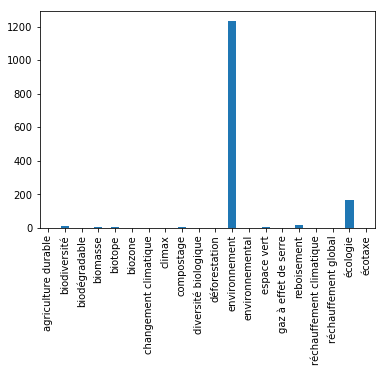

In [51]:
matched_words_gdl['Word found'].value_counts().add(df_UA_gdl['Word found'].value_counts(), fill_value='0').plot('bar')

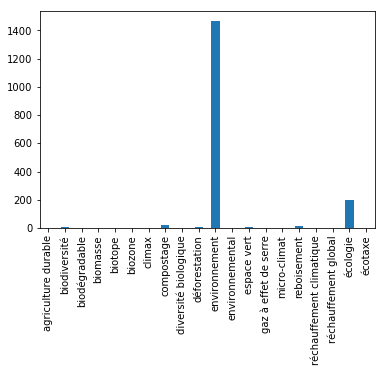

In [52]:
matched_words_jdg['Word found'].value_counts().add(df_UA_jdg['Word found'].value_counts(), fill_value='0').plot('bar')

In [53]:
occurences_ofWords_gdl = matched_words_gdl['Word found'].value_counts().add(df_UA_gdl['Word found'].value_counts(), fill_value='0')
occurences_ofWords_jdg = matched_words_jdg['Word found'].value_counts().add(df_UA_jdg['Word found'].value_counts(), fill_value='0')

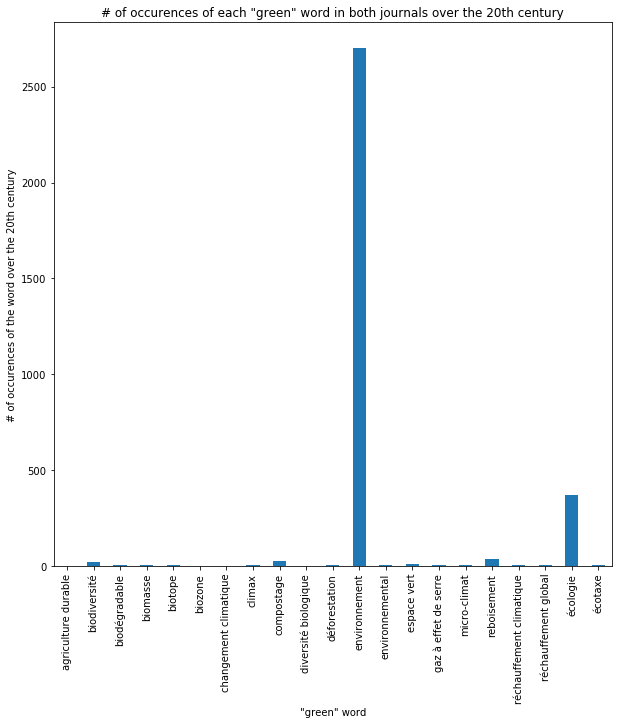

In [54]:
fig = plt.figure(figsize=(10, 10))
occurences_ofWords_gdl.add(occurences_ofWords_jdg, fill_value = '0').sort_index().plot('bar')
plt.title('# of occurences of each "green" word in both journals over the 20th century')
plt.xlabel('"green" word')
plt.ylabel('# of occurences of the word over the 20th century')
pylab.savefig('occurences_greenWordsOverCentury_bothJournals.png')

**Observations:**<br>
It does not come as a surprise that the word 'environnement' is predominant in our pre-processed dataset. The word 'écologie' is also showing up a little. Compared to these two, the other "green" words have a very little contribution to the dataset. The domination of the 'environnement' word needs to be treated carefully as this word in french can be used in several other contexts. That is why we randomly verified that most of the retrieved articles were indeed talking about "green" subjects. Moreover, topic modelling which will be introduced further down will allow us to see if the extraction of the 'environment' related articles has brought on the table subjects that does not relate to "green" topics.

**We are now going to look into the evolution of "green" articles over time by displaying the number of occurences of all green words combined in regard of the issuing year dates of related articles. We plot this for each journal first and for both journals combined afterwards.**

In [55]:
df_UA_gdl['Issue Date'] = pd.to_datetime(df_UA_gdl['Issue Date'], dayfirst = True)

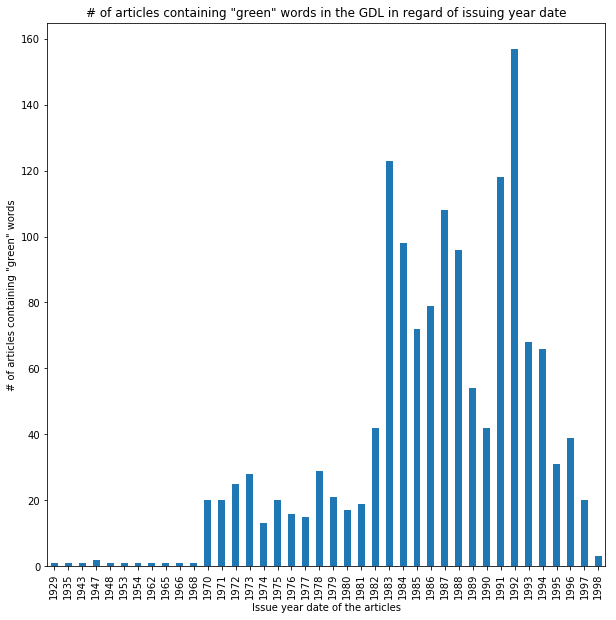

In [56]:
fig = plt.figure(figsize=(10, 10))
matched_words_gdl['Issue Date'].dt.year.value_counts().add(df_UA_gdl['Issue Date'].dt.year.value_counts(), fill_value='0').sort_index().plot('bar')
plt.title('# of articles containing "green" words in the GDL in regard of issuing year date')
plt.xlabel('Issue year date of the articles')
plt.ylabel('# of articles containing "green" words')
pylab.savefig('occurences_greenWords_gdl.png')

In [57]:
df_UA_jdg['Issue Date'] = pd.to_datetime(df_UA_jdg['Issue Date'], dayfirst = True)

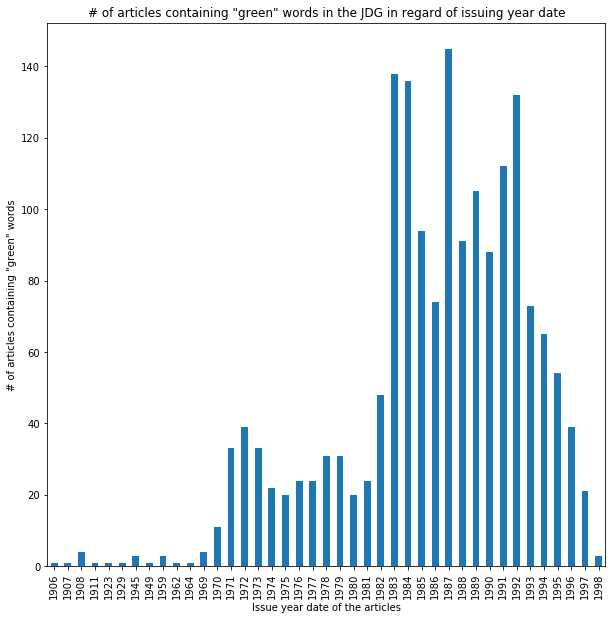

In [58]:
fig = plt.figure(figsize=(10, 10))
matched_words_jdg['Issue Date'].dt.year.value_counts().add(df_UA_jdg['Issue Date'].dt.year.value_counts(), fill_value='0').sort_index().plot('bar')
plt.title('# of articles containing "green" words in the JDG in regard of issuing year date')
plt.xlabel('Issue year date of the articles')
plt.ylabel('# of articles containing "green" words')
pylab.savefig('occurences_greenWords_jdg.png')

In [59]:
occurences_overTime_gdl = matched_words_gdl['Issue Date'].dt.year.value_counts().add(df_UA_gdl['Issue Date'].dt.year.value_counts(), fill_value='0').sort_index()
occurences_overTime_jdg = matched_words_jdg['Issue Date'].dt.year.value_counts().add(df_UA_jdg['Issue Date'].dt.year.value_counts(), fill_value='0').sort_index()

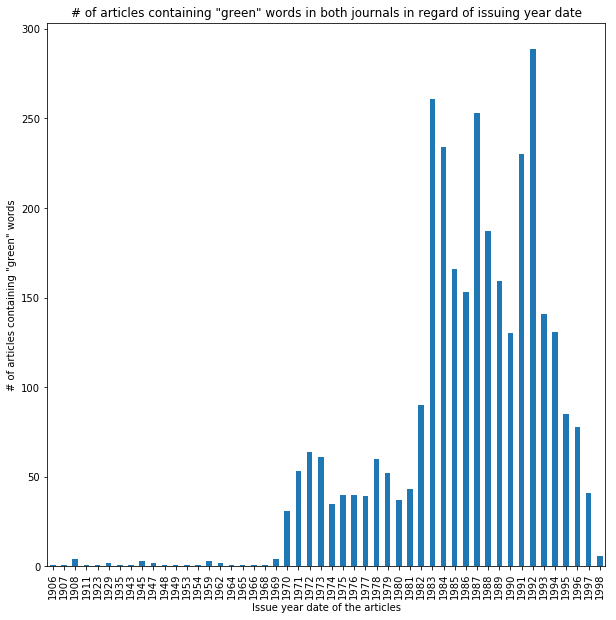

In [60]:
fig = plt.figure(figsize=(10, 10))
occurences_overTime_gdl.add(occurences_overTime_jdg, fill_value = '0').sort_index().plot('bar')
plt.title('# of articles containing "green" words in both journals in regard of issuing year date')
plt.xlabel('Issue year date of the articles')
plt.ylabel('# of articles containing "green" words')
pylab.savefig('occurences_greenWords_bothJournals.png')

**Observations:**<br>
- Interesting fact is that the trends in the rise of popularity of "green" topics occur at the same time in both journals
- Before the 70s very few articles mentioned anything about "green"subjects
- Another fall is accountable at the end of the 90s

# Part 6

**Topic Modelling**

**Step 1: Retrieving all articles' content from GDL and JDG in two separated lists**

In [61]:
articles_gdl = []
for word in list(matched_words_gdl['Word found'].unique()):
    fileobj = open(os.path.join(ARTICLES_FOLDER, word +'_gdl'), 'rb')
    articles_fullText = pickle.load(fileobj, encoding = 'utf8')
    articles_gdl.append(articles_fullText)
articles_gdl.append(UA_fullText_gdl) 
#flatten list
articles_gdl = [y for x in articles_gdl for y in x]

In [62]:
articles_jdg = []
for word in list(matched_words_jdg['Word found'].unique()):
    fileobj = open(ARTICLES_FOLDER+'/'+word+'_jdg', 'rb')
    articles_fullText = pickle.load(fileobj)
    articles_jdg.append(articles_fullText)
articles_jdg.append(UA_fullText_jdg)   
#flatten list
articles_jdg = [y for x in articles_jdg for y in x]

**Step 2: Retrieving the titles of the articles in the same order as they are in the list of contents**

In [63]:
titles_list_gdl = matched_words_gdl['Article Name'].tolist() + df_UA_gdl['Article Name'].tolist()

In [64]:
titles_list_jdg = matched_words_jdg['Article Name'].tolist() + df_UA_jdg['Article Name'].tolist()

**Optional step: As we have seen that "green" word "environnement" is the predominant term of the "green" list, we retrieve all articles' for environment only for enventual comparison afterwards**

In [65]:
#gdl

In [66]:
word = 'environnement'    
fileobj = open(ARTICLES_FOLDER+'/'+word+'_gdl', 'rb')
articles_env_gdl = pickle.load(fileobj)
index_of_UA_env = list(df_UA_gdl[df_UA_gdl['Word found'] == 'environnement'].index)
articles_env_gdl = articles_env_gdl + list(itemgetter(*index_of_UA_env)(UA_fullText_gdl))

In [67]:
len(articles_env_gdl)

1233

In [68]:
#jdg

In [69]:
word = 'environnement'    
fileobj = open(ARTICLES_FOLDER+'/'+word+'_jdg', 'rb')
articles_env_jdg = pickle.load(fileobj)
index_of_UA_env = list(df_UA_jdg[df_UA_jdg['Word found'] == 'environnement'].index)
articles_env_jdg = articles_env_jdg + list(itemgetter(*index_of_UA_env)(UA_fullText_jdg))

In [70]:
len(articles_env_jdg)

1467

In [71]:
# Retrieving titles of "environnement" articles above

In [72]:
titles_env_gdl = matched_words_gdl[matched_words_gdl['Word found'] == 'environnement']['Article Name'].tolist() + df_UA_gdl[df_UA_gdl['Word found'] == 'environnement']['Article Name'].tolist()

In [73]:
titles_env_jdg = matched_words_jdg[matched_words_jdg['Word found'] == 'environnement']['Article Name'].tolist() + df_UA_jdg[df_UA_jdg['Word found'] == 'environnement']['Article Name'].tolist()

**Step3: Joint list of articles from jdg and gdl**

In [74]:
articles = articles_gdl + articles_jdg

In [75]:
#lowercase the articles
articles = [article.lower() for article in articles]

In [76]:
titles = titles_list_gdl + titles_list_jdg

In [77]:
len(articles), len(titles)

(3223, 3223)

**Optional step: Joint list of articles retrieved by green word "environnement" from jdg and gdl**

In [78]:
articles_env = articles_env_gdl + articles_env_jdg

In [79]:
#lowercase the articles
articles_env = [article.lower() for article in articles_env]

In [80]:
titles_env = titles_env_gdl + titles_env_jdg

**Step 4: Dealing with stop words**<br>
In topic modelling, stop words are essential to prevent our algorithms from distingiushing topics based on vocab that is not relevant. We have used two lists of french stop words: one from the nltk package and another one from the stop_words package. We have also added our own stopwords which found to be present in the top words of top topics when doing our analysis. We have also removed all words which length is under 4 charachters as these words of such size are often not relevant in french. 

In [81]:
from nltk.corpus import stopwords
import nltk

In [82]:
# first stop words list
stop = list(stopwords.words('french'))

In [83]:
# our stop words
stop.append('contre')
stop.append('entre')
stop.append('jusqu')
stop.append('aujourd')
stop.append('autres')
stop.append('toutes')
stop.append('selon')
stop.append('ainsi')
stop.append('cours')
stop.append('notamment')
stop.append('suisses') # suisse already present
stop.append('banques') # banque already present 
stop.append('grand')
stop.append('après')
stop.append('toujours')
stop.append('quelques')
stop.append('fédérale')

In [84]:
from stop_words import get_stop_words

In [85]:
# second stop words list
stop_words = get_stop_words('fr')

In [86]:
# gather all stop words
all_stop_words = list(set(stop).union(set(stop_words)))

# Pre-processing articles

**Getting rid of punctuation, numbers and stop_words**

In [87]:
articles_token = [nltk.word_tokenize(b) for b in articles]

In [88]:
import string
punctuation = string.punctuation+'“’—.”’“--,”'+'«'+'»' # pimp the list of punctuation to remove
for i in range(len(articles_token)):
    ind = []
    for j in range(len(articles_token[i])):
        if articles_token[i][j] in punctuation:
            ind.append(j)
        if articles_token[i][j].isdigit():
            ind.append(j)
        if articles_token[i][j] in all_stop_words:
            ind.append(j)
        for l in range(len(articles_token[i][j])):
            if articles_token[i][j][l] in punctuation:
                ind.append(j)
            if articles_token[i][j][l].isdigit():
                ind.append(j)
    articles_token[i] = np.asarray(articles_token[i])
    articles_token[i] = list(np.delete(articles_token[i], ind))

In [89]:
# Here we get rid of less than 4 characters' words and reshape list of articles by joining tokens from each article
for i in range(len(articles_token)):
    ind = []
    for j in range(len(articles_token[i])):
        if len(articles_token[i][j]) <=4:
            ind.append(j)
    articles_token[i] = np.asarray(articles_token[i])
    articles_token[i] = list(np.delete(articles_token[i], ind))
    articles_token[i] = ' '.join(articles_token[i])

**Stemming text**<br>
Stemming is a process of removing and replacing word suffixes to arrive at a common root form of the word. We have tried to use the SnowballStemmer to clean our text. But the outcomes of this cleaning was not very pertinent as it failed to recognize real root form of words. In order, to prevent ourselves from removing words which need not to be, we have skipped this pre-processing step for now.

**Topic modelling process**<br>

In [90]:
import sklearn.feature_extraction.text as text

In [91]:
# Here we define our text vectorizer by specifying our list of stop words and min/max frequency of words 
# required to be considered as mattering words
vectorizer = text.CountVectorizer(input = 'content', min_df = 0.01, max_df = 0.7, stop_words = all_stop_words, analyzer = 'word')

In [92]:
# Vectorization of words + retrieving of feature names
articles_copy = articles_token.copy()
dtm = vectorizer.fit_transform(articles_copy).toarray()
vocab = np.array(vectorizer.get_feature_names())

In [93]:
dtm.shape

(3223, 2501)

In [94]:
len(vocab)

2501

In [95]:
from sklearn import decomposition

In [96]:
num_topics = 10
num_top_words = 10
clf = decomposition.NMF(n_components=num_topics, random_state=1)
doctopic = clf.fit_transform(dtm)
nn_indices = np.where(np.sum(doctopic, axis = 1, keepdims = True) != 0)
nn_indices = nn_indices[0]
# sum of probabilities to one
doctopic[nn_indices] = doctopic[nn_indices] / np.sum(doctopic[nn_indices], axis=1, keepdims=True)

In [97]:
# get topic words in list
topic_words = []
for topic in clf.components_:
    word_idx = np.argsort(topic)[::-1][0:num_top_words]
    topic_words.append([vocab[i] for i in word_idx])

In [98]:
#display 10 first articles and 3 top associated topics
for i in range(len(doctopic[:10,:])):
    top_topics = np.argsort(doctopic[i,:])[::-1][0:3]
    top_topics_str = ' '.join(str(t) for t in top_topics)
    print("{}: {}".format(titles[i], top_topics_str))

Le reboisement de la Palestine: 8 1 4
Reboisement de la Galilée: 8 0 7
Le reboisement des forêts ravagées par l'ouragan: 8 0 3
I& REBOISEMENT DE LA CHINE: 0 8 1
Les travaux de la Société des sciences naturelles La lutte contre l'érosion par le reboisement: 8 0 5
De grands travaux de reboisement vont être entrepris dans la région de la Dent de Jaman: 5 8 1
GOVENTRY CLIMAX: 8 0 9
FAO L'homme, victime imprudente, fera-t-il reculer le désert? Une possibilité : le reboisement: 8 0 2
DEMAIN SOIR CONFÉRENCE ACADÉMIQUE SUR L'ÉCOLOGIE: 3 8 1
INFORMATIONS SUISSES HIER SOIR A LAUSANNE L'écologie et le monde moderne: 8 0 4


In [99]:
# display topics and top words 
for t in range(len(topic_words)):
    print("Topic {}: {}".format(t, ' '.join(topic_words[t])))

Topic 0: nature temps politique problèmes écologique monde société production exemple problème
Topic 1: conseil commission fédéral national etats projet droit recours cantons conseiller
Topic 2: déchets tonnes spéciaux communes traitement compostage recyclage installations berne ordures
Topic 3: suisse fédéral berne environnement fondation convention transports conférence ministres conseiller
Topic 4: développement conférence nations durable unies commerce mondiale monde économique internationale
Topic 5: protection nature projet fédéral cantons mesures bruit berne matière nouvelle
Topic 6: pollution mesures émissions rapport véhicules voitures réduire environnement normes polluants
Topic 7: genève ville canton secrétariat département centre directeur organisations genevois internationale
Topic 8: forêts fédéral forêt berne arbres dégâts forestière cantons dépérissement mesures
Topic 9: marché millions hausse points francs baisse banque semaine milliards rendement


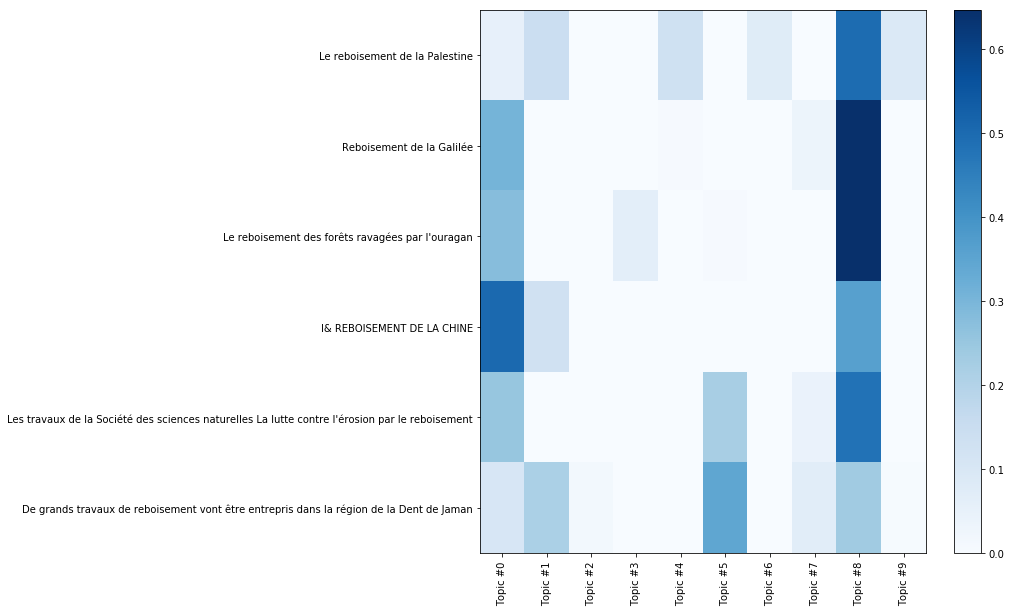

In [100]:
# heatmap 
figure = plt.figure(figsize = (10,10))
plt.pcolor(doctopic[:6], norm=None, cmap='Blues')
plt.yticks(np.arange(doctopic[:6].shape[0])+0.5, titles[:6]);
K = 10
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.xticks(np.arange(doctopic[:6].shape[1])+0.5, topic_labels);
plt.gca().invert_yaxis()
plt.xticks(rotation=90)
plt.colorbar(cmap='Blues')
plt.savefig(ADA_DIR + '/plots/heatmap.png')
plt.show()

**Computing strengh association to topic for top words**

In [112]:
stats_topics = []
for i, words in enumerate(topic_words):
    stats_tmp = []
    for word in words: 
        cpt = 0
        cpt_topic = 0
        for j, article in enumerate(articles_copy):
            if word in article:
                cpt += 1
                if np.argsort(doctopic[j,:])[::-1][0] == i:
                    cpt_topic += 1
        stats_tmp.append(cpt_topic/cpt)
    stats_topics.append(stats_tmp)            

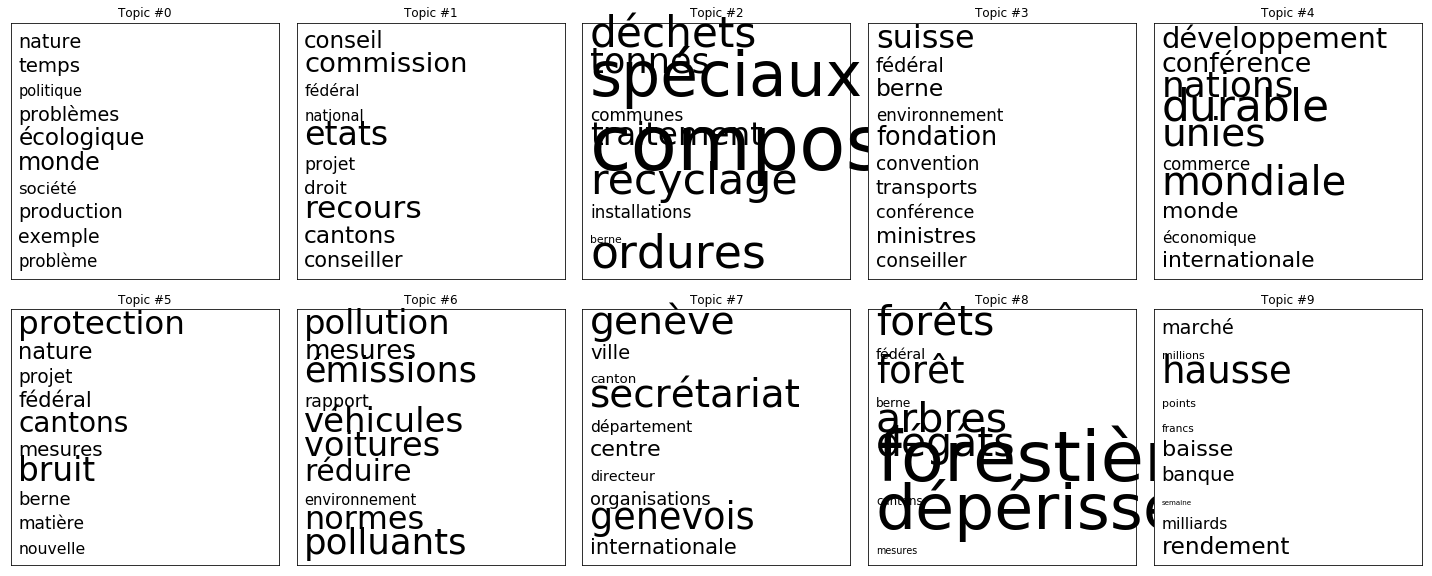

In [128]:
# strength association with a topic
num_topics = 10
num_top_words = 10
figure = plt.figure(figsize = (20,20))
for t in range(num_topics):
    plt.subplot(5, 5, t + 1)  # plot numbering starts with 1
    plt.ylim(0, num_top_words + 0.5)  # stretch the y-axis to accommodate the words
    plt.xlim(0, num_top_words + 0.5)  # stretch the y-axis to accommodate the words
    plt.xticks([])  # remove x-axis markings ('ticks')
    plt.yticks([]) # remove y-axis markings ('ticks')
    plt.title('Topic #{}'.format(t))
    top_words_idx = np.argsort(doctopic[:,t])[::-1]  # descending order
    top_words_idx = top_words_idx[:num_top_words]
    top_words = topic_words[t]
    top_words_shares = stats_topics[t]
    for i, (word, share) in enumerate(zip(top_words, top_words_shares)):
        plt.text(0.3, num_top_words-i-0.5, word, fontsize=100*share)
plt.tight_layout()
plt.savefig(ADA_DIR + '/plots/topics')

**Observations:**<br>
- The heatmap gives great and quick information on which topics can better represent a set of articles retrieved by a specific "green" word. As provided in the above example for "reboisement" articles from the gdl, the topic 8 is dominant and it is perfectly correct when we look at top words of topic 8 which relate to forest, tree etc. 
- The strength association is very interesting to get a sense of the correlation between topic association and importance of top words. We can be satisfied with this results as it shows that often we can rely on a strong association between top words and topic classification.
- We can also observe that despite the need to process more our articles' content, the topic modeling is relevant and the topics learnt make sense. Especially when looking at top words of each topic they really have similiarity in meaning and gather correlated themes.
- Our fear of bringing bias by including 'environnement' articles which may sometimes not relate at all to "green" matters does not seem to influence the topic modeling so it shows that such articles are not very present in the dataset.